In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
from pathlib import Path
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
# from livelossplot.keras import PlotLossesCallback


import pandas as pd
import numpy as np
import tensorflow as tf
import warnings
import requests
import matplotlib.pyplot as plt
import seaborn as snsgs
import datetime
import calendar

from tensorflow import keras
from keras.models import Sequential 
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error
from sklearn.exceptions import DataConversionWarning

import warnings
warnings.filterwarnings(action='ignore')


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)


* ref : https://www.kaggle.com/rajmehra03/bike-sharing-demand-rmsle-0-3194

In [2]:
def expanded_index_datetime_col(data):
    data = data.copy()
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data["day"] = data.index.day
    data["month"] = data.index.month
    data["year"] = data.index.year
    return data

def replaced_with_onehot_cols(data, col_names):
    data = data.copy()
    
    for col_name in col_names:
        one_hot = pd.get_dummies(data[col_name], prefix=col_name)
        data = data.join(one_hot)
        
        # Original column is not needed anymore
        del data[col_name]
    return data


In [3]:
TRAIN_DATA = pd.read_csv('./bike_datasets/train.csv', parse_dates=True, index_col="datetime")
TEST_DATA = pd.read_csv('./bike_datasets/test.csv', parse_dates=True, index_col="datetime")
print(TRAIN_DATA.shape, TEST_DATA.shape)

(10886, 11) (6493, 8)


In [4]:
TRAIN_DATA.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [5]:
TRAIN_DATA.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  count       10886 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 1020.6 KB


### Missing Timestamps
* 2years∗12months∗19days∗24hours=10944
* 1month = 456
* train_shape : 10886 
* ref : https://www.kaggle.com/drcapa/bike-sharing-demand-rnn

In [6]:
num_months_per_year = 12
year_list = [2011, 2012]

In [7]:
train_data_temp = pd.DataFrame(columns=TRAIN_DATA.columns)

for year in year_list:
    for month in range(num_months_per_year):
        start_date = datetime.datetime(year, month+1, 1, 0, 0, 0)
        end_date = datetime.datetime(year, month+1, 19, 23, 0, 0)
        # Fill missing timestamps
        temp = TRAIN_DATA[start_date:end_date].resample('H').asfreq()

        temp[['casual', 'registered', 'count']] = temp[['casual', 'registered', 'count']].fillna(0)
        temp[['season', 'holiday', 'workingday', 'weather']] = temp[['season', 'holiday', 'workingday', 'weather']].fillna(method='bfill')
        temp[ ['temp', 'atemp', 'humidity', 'windspeed']] = temp[ ['temp', 'atemp', 'humidity', 'windspeed']].interpolate(method='linear')
        
        train_data_temp = train_data_temp.append(temp)
        
TRAIN_DATA = train_data_temp

In [8]:
del train_data_temp

In [9]:
print(TRAIN_DATA.shape, TEST_DATA.shape)  #(10886, 11) (6493, 8) --> (10944, 11) (6600, 8)

(10944, 11) (6493, 8)


In [10]:
TRAIN_DATA.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
2011-01-01 00:00:00,1.0,0.0,0.0,1.0,9.84,14.395,81.0,0.0,3.0,13.0,16.0
2011-01-01 01:00:00,1.0,0.0,0.0,1.0,9.02,13.635,80.0,0.0,8.0,32.0,40.0
2011-01-01 02:00:00,1.0,0.0,0.0,1.0,9.02,13.635,80.0,0.0,5.0,27.0,32.0
2011-01-01 03:00:00,1.0,0.0,0.0,1.0,9.84,14.395,75.0,0.0,3.0,10.0,13.0
2011-01-01 04:00:00,1.0,0.0,0.0,1.0,9.84,14.395,75.0,0.0,0.0,1.0,1.0


In [11]:
TRAIN_DATA[['season', 'holiday', 'workingday', 'weather']] = TRAIN_DATA[['season', 'holiday', 'workingday', 'weather']].astype('int')

In [12]:
TRAIN_DATA.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81.0,0.0,3.0,13.0,16.0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80.0,0.0,8.0,32.0,40.0
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80.0,0.0,5.0,27.0,32.0
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75.0,0.0,3.0,10.0,13.0
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75.0,0.0,0.0,1.0,1.0


In [13]:
TRAIN_DATA = expanded_index_datetime_col(TRAIN_DATA)
TEST_DATA = expanded_index_datetime_col(TEST_DATA)
print(TRAIN_DATA.shape, TEST_DATA.shape)  #(10944, 16) (6600, 13)

(10944, 16) (6493, 13)


In [14]:
# TRAIN_DATA.groupby(['year','month','day'])['count'].mean()[:60]

In [15]:
TRAIN_DATA.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,weekday,day,month,year
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81.0,0.0,3.0,13.0,16.0,0,5,1,1,2011
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80.0,0.0,8.0,32.0,40.0,1,5,1,1,2011
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80.0,0.0,5.0,27.0,32.0,2,5,1,1,2011
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75.0,0.0,3.0,10.0,13.0,3,5,1,1,2011
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75.0,0.0,0.0,1.0,1.0,4,5,1,1,2011


In [16]:
TRAIN_DATA = TRAIN_DATA.drop(["casual", "registered"], axis=1)

In [17]:
TRAIN_DATA = replaced_with_onehot_cols(TRAIN_DATA, col_names=["season", "holiday", "workingday","weather",  "weekday", "month", "year"]) 
TEST_DATA = replaced_with_onehot_cols(TEST_DATA, col_names=["season", "holiday", "workingday","weather",  "weekday","month", "year"]) 

display(TRAIN_DATA.head())
print(TRAIN_DATA.shape, TEST_DATA.shape)  #(10944, 40) (6600, 39)

,temp,atemp,humidity,windspeed,count,hour,day,season_1,season_2,season_3,season_4,holiday_0,holiday_1,workingday_0,workingday_1,weather_1,weather_2,weather_3,weather_4,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_2011,year_2012
2011-01-01 00:00:00,9.84,14.395,81.0,0.0,16.0,0,1,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2011-01-01 01:00:00,9.02,13.635,80.0,0.0,40.0,1,1,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2011-01-01 02:00:00,9.02,13.635,80.0,0.0,32.0,2,1,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2011-01-01 03:00:00,9.84,14.395,75.0,0.0,13.0,3,1,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2011-01-01 04:00:00,9.84,14.395,75.0,0.0,1.0,4,1,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0


(10944, 40) (6493, 39)


In [18]:
train = TRAIN_DATA[TRAIN_DATA["day"] <= 16]
print(f"train day: {train['day'].min()}-{train['day'].max()}")
val = TRAIN_DATA[TRAIN_DATA["day"] > 16]
print(f"val day: {val['day'].min()}-{val['day'].max()}")
print(f"test day: {TEST_DATA['day'].min()}-{TEST_DATA['day'].max()}")
print(train.shape, val.shape, TEST_DATA.shape)  #(9216, 40) (1728, 40) (6600, 39)

train day: 1-16
val day: 17-19
test day: 20-31
(9216, 40) (1728, 40) (6493, 39)


In [19]:
def normalized_cols(df, scaler):
    df = df.copy()
    return pd.DataFrame(scaler.fit_transform(df.values), columns=df.columns, index=df.index)

scaler = MinMaxScaler()
X_train = normalized_cols(df=train.drop("count", axis=1), scaler=scaler)
y_train = normalized_cols(df=train[["count"]], scaler=scaler)

X_val = normalized_cols(df=val.drop("count", axis=1), scaler=scaler)
y_val = normalized_cols(df=val[["count"]], scaler=scaler)


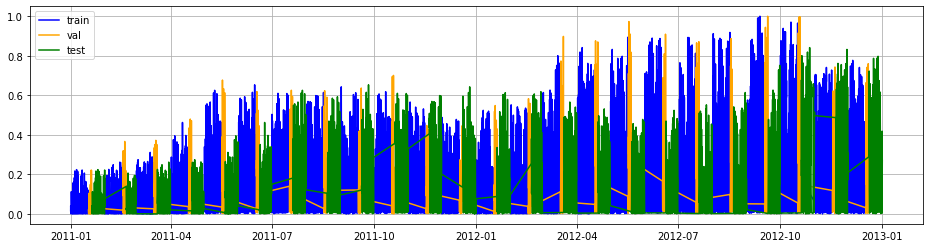

In [20]:
fig = plt.figure(figsize=(16,4))
plt.plot(y_train.index, y_train['count'], 'blue', label='train')
plt.plot(y_val.index, y_val['count'], 'orange', label='val')
plt.plot(TEST_DATA.index, y_train['count'][:TEST_DATA.shape[0]] , 'green', label='test')
plt.legend()
plt.grid()

In [21]:
def mymake_dataset(data, label, window_size=24):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

print(X_train.shape)  #(9216, 39)
X_train_arr, y_train_arr = mymake_dataset(X_train, y_train)
print(X_train_arr.shape, y_train_arr.shape)  #(9192, 24, 39) (9192, 1)

print(X_val.shape)  #(1728, 39)
X_val_arr, y_val_arr = mymake_dataset(X_val, y_val)
print(X_val_arr.shape, y_val_arr.shape)  #(9216, 40) (1728, 40)

(9216, 39)
(9192, 24, 39) (9192, 1)
(1728, 39)
(1704, 24, 39) (1704, 1)


In [22]:
def score_msle(y_true, y_pred):
    loss = np.mean(np.square(np.log(y_true + 1.) - np.log(y_pred + 1.)), axis=-1)
    return np.sqrt(loss)


model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train_arr.shape[1], X_train_arr.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(units=50))
model.add(Dropout(0.4))
model.add(Dense(units=1))
model.summary()

model.compile(optimizer='rmsprop',loss='mse',  metrics=[tf.keras.metrics.MeanSquaredLogarithmicError(name='msle')])
# model.compile(optimizer='adam', loss='mse', metrics=[score_msle])
# model.compile(optimizer='rmsprop', loss='msle', metrics='msle')



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 24, 64)            26624     
_________________________________________________________________
dropout (Dropout)            (None, 24, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 24, 50)            23000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 24, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [23]:
estop = EarlyStopping(monitor='val_loss', patience=5)
res = model.fit(X_train_arr, y_train_arr, 
        batch_size=256, 
        validation_split=0.2,
        shuffle=False,
        epochs=100,
        callbacks=[estop])    

Epoch 1/100
29/29 [==============================] - 32s 249ms/step - loss: 0.0338 - msle: 0.0155 - val_loss: 0.0480 - val_msle: 0.0212
Epoch 2/100
29/29 [==============================] - 5s 164ms/step - loss: 0.0188 - msle: 0.0200 - val_loss: 0.0484 - val_msle: 0.0202
Epoch 3/100
29/29 [==============================] - 5s 166ms/step - loss: 0.0163 - msle: 0.0195 - val_loss: 0.0348 - val_msle: 0.0190
Epoch 4/100
29/29 [==============================] - 5s 164ms/step - loss: 0.0124 - msle: 0.0182 - val_loss: 0.0358 - val_msle: 0.0176
Epoch 5/100
29/29 [==============================] - 5s 162ms/step - loss: 0.0111 - msle: 0.0171 - val_loss: 0.0323 - val_msle: 0.0165
Epoch 6/100
29/29 [==============================] - 5s 163ms/step - loss: 0.0136 - msle: 0.0162 - val_loss: 0.0264 - val_msle: 0.0156
Epoch 7/100
29/29 [==============================] - 5s 163ms/step - loss: 0.0106 - msle: 0.0153 - val_loss: 0.0281 - val_msle: 0.0148
Epoch 8/100
29/29 [==============================] - 5

In [24]:
np.sqrt(0.0060)

0.07745966692414834

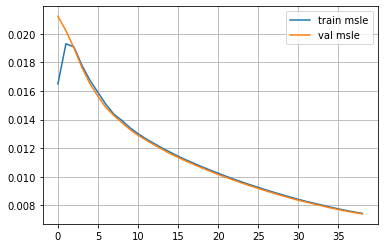

In [25]:
fig,ax = plt.subplots()
plt.plot(res.history['msle'], label='train msle')
plt.plot(res.history['val_msle'], label='val msle')
plt.grid()
# plt.title(f"RMSLE : {res.history['rmse'][-1:]}")
plt.legend()

In [321]:
dataset_train = pd.concat([X_train, X_val])
print(dataset_train.shape)
print(TEST_DATA.shape)
dataset_total = pd.concat((dataset_train, TEST_DATA), axis =0)
print(dataset_total.shape)
inputs = dataset_total[len(dataset_total) - len(TEST_DATA) - 24: ].values  # train[-windowsize+1:] len(TEST_DATA)
print(inputs.shape)  #TEST_DATA+24  (6517,39)

(10944, 39)
(6493, 39)
(17437, 39)
(6517, 39)


In [ ]:
# ref : 
# https://towardsdatascience.com/lstm-time-series-forecasting-predicting-stock-prices-using-an-lstm-model-6223e9644a2f


In [322]:
def mymake_dataset(data, window_size=24):
    feature_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data[i:i+window_size]))
    return np.array(feature_list)

print(inputs.shape)  #(6517, 51)
inputs_arr = mymake_dataset(inputs)
print(inputs_arr.shape)  #(9192, 24, 39) (9192, 1)


(6517, 39)
(6493, 24, 39)


In [323]:
pred = model.predict(inputs_arr)

In [324]:
pred.shape

(6493, 24, 1)

In [326]:
predicted_stock_price = scaler.inverse_transform(pred.reshape(-1,1))
predicted_stock_price.shape

(155832, 1)

In [ ]:
dfd

In [315]:
sub = pd.read_csv('./bike_datasets/sampleSubmission.csv')
sub.shape

(6493, 2)